# Unit 4 Capstone 
Author: Bryan Corder <br>
Mentor: Hoa Tran <br>

People who study wine, know there are certain aromas associated with varieties such as black currants with Cabernet Sauvignon. The average consumer is right to be skeptical about wine descriptions when they range from "freshly cut garden hose" to "petrol" when it would be a health violation if any of those were actually put into wine.

However, there is science behind these terms. Pyrazines, which are found in bell peppers and give peppers their aroma, are found in both Cabernet Franc and its offspring (together with Sauvignon Blanc) variety, Cabernet Sauvignon giving both a touch of a "bell pepper" like vegetal quality. Similarly, the same kind of compounds are responsible for aromas of red fruits like strawberries or cherries or stone fruits like peaches or nectarines. Some come from the grape varieties like the above mentioned pyrazines and some aromas come from the wine making process, such as cedar or vanilla from the oak aging process.

Wine descriptions offer information to the consumer about the grape used and the process taken to turn the grapes into the beverage the consumer is imbibing.

This project looks into whether it is possible to create a model to discern through wine descriptions what kind of grape is used to produce the wine. This may seem like a trivial task, but it was not until the mid 1990s until wine consumers found out that the unique expression of Merlot they were drinking from Chile was in fact another Bordeaux variety named Carmenere. Mexicans in Baja California claim all of their grapes are Nebbiollo even though when wine grapes from Piedmont, Italy were brought to Mexico, the tags became illegible with the moisture and it was only assumed that those vines were Nebbiollo. In all likelihood, what we call a Mexican Nebbiollo is actually a blend of Piedmont grapes such as Nebbiollo, Barbera, and Dolcetto. (Source: Karen MacNeil, __Wine Bible__) 

After a model is created, this project will use the data to see if any other insights can be gained about grape varieties through unsupervised learning techniques.

In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import unicodedata
from datetime import datetime

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import re


from collections import Counter
%matplotlib inline

## Data
The data comes from Kaggle: https://www.kaggle.com/sierram/cosine-similarity-wine-descriptions/data
The data includes the wine name, source, decription, price, wine producer, and author of the description. Since this study is trying to use the data to name grape varieties, only the description and variety are used.

Due to limited processing power, this project will only look at the three most common varietals in the data set.

In [2]:
raw_data = pd.read_csv('winemag-data-130k-v2.csv')
raw_data.head(10)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
7,7,France,This dry and restrained wine offers spice in p...,NaN,87,24.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Trimbach 2012 Gewurztraminer (Alsace),Gewürztraminer,Trimbach
8,8,Germany,Savory dried thyme notes accent sunnier flavor...,Shine,87,12.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Heinz Eifel 2013 Shine Gewürztraminer (Rheinhe...,Gewürztraminer,Heinz Eifel
9,9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [3]:
# All we'll need are the country, description and variety. There is one data point without a variety, so let's drop it.
wine_data = raw_data[['country', 'description', 'variety']].dropna()

# The word description will come up in our data, so we need to change the name of the column for clarity.
wine_data = wine_data.rename(columns = {'description': 'description_text'})

# Make all of the varieties lower case so that Pinot Noir and pinot noir are recognized as the same
wine_data['variety'] = wine_data['variety'].str.lower()
wine_data['country'] = wine_data['country'].str.lower()

wine_data.head(10)

,country,description_text,variety
0,italy,"Aromas include tropical fruit, broom, brimston...",white blend
1,portugal,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,us,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,us,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,us,"Much like the regular bottling from 2012, this...",pinot noir
5,spain,Blackberry and raspberry aromas show a typical...,tempranillo-merlot
6,italy,"Here's a bright, informal red that opens with ...",frappato
7,france,This dry and restrained wine offers spice in p...,gewürztraminer
8,germany,Savory dried thyme notes accent sunnier flavor...,gewürztraminer
9,france,This has great depth of flavor with its fresh ...,pinot gris


There are umlauts and accents, so let's clean that up so the computer recognizes them as the same terms.

In [4]:
# Get rid of the special characters like the umlaut on the u in gewurztraminer
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

wine_data['variety'] = wine_data['variety'].apply(remove_accents)
wine_data['description_text'] = wine_data['description_text'].apply(remove_accents)
   
wine_data.head(10)

,country,description_text,variety
0,italy,"Aromas include tropical fruit, broom, brimston...",white blend
1,portugal,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,us,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,us,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,us,"Much like the regular bottling from 2012, this...",pinot noir
5,spain,Blackberry and raspberry aromas show a typical...,tempranillo-merlot
6,italy,"Here's a bright, informal red that opens with ...",frappato
7,france,This dry and restrained wine offers spice in p...,gewurztraminer
8,germany,Savory dried thyme notes accent sunnier flavor...,gewurztraminer
9,france,This has great depth of flavor with its fresh ...,pinot gris


In [5]:
# Make sure it is not containing Null values
null_count = wine_data.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

Now, let's look at the counts of varieties in the data set.

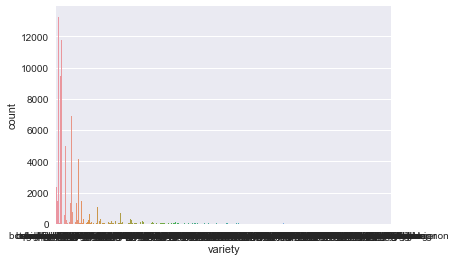

In [6]:
sns.countplot(x='variety', data=wine_data)
plt.show()

There are a lot of varieties, and several that do not even really register on the graph because they have so few reviews. For this study, due to my limited processing power, I am only going to focus on the three most common varieties: Cabernet Sauvignon (red), Pinot Noir (red), and Chardonnay (white). If processing power were not an issue, I would have consolidated the number of varieties with just a few descriptions because the computer would not be able to accurately classify them. There are also varieties in there that are "blends" which would be difficult to classify because the chemical compounds from several varieties would be in there and the computer would not be able to distinguish which ones were in there by the description.

So, let's focus on the top three varieties bringing down the number of samples to an even 7000 apiece to balance the sample.

In [7]:
# Let's get rid of generic blends
print('There are this many varieties that contain the word blend or "red"')
print(len(wine_data[wine_data.variety.str.contains('blend') == True]) + 
      len(wine_data[wine_data.variety.str.contains('red') == True]))
wine_data = wine_data[wine_data.variety.str.contains('blend') == False]
wine_data = wine_data[wine_data.variety.str.contains('red') == False]

# First we need to find out what varieties are the popular ones by putting on variety counts
variety_counts = wine_data['variety'].value_counts().rename('variety_counts')

# Attach the counts to the dataframe
wine_data = wine_data.merge(variety_counts.to_frame(),
                                left_on='variety', right_index=True)

# Define what a popular variety is and then get rid of the variety counts
popular_varieties = wine_data[wine_data['variety_counts'] > 7000]
wine_data = wine_data.drop(['variety_counts'], axis=1)

# Set those varieties as a list
popular_varieties = set(popular_varieties['variety'])

There are this many varieties that contain the word blend or "red"
45623


In [8]:
# Balance the samples by under sampling
columns_list = list(wine_data.columns.values)
test_df = pd.DataFrame(columns=columns_list)

for x in popular_varieties:
    # Create a local df for the resampling
    temp_df = pd.DataFrame(columns=columns_list)
    
    # Break up the data between the big ones and rest
    temp_df = wine_data[wine_data['variety'] == x]
    
    temp_df = resample(temp_df, n_samples=6000)
    test_df = test_df.append(temp_df, ignore_index=True)

# This will be the dataframe used for testing
print(test_df.head(10))

  country                                   description_text  \
0      us  This is a sound Cabernet Sauvignon. It's very ...   
1   chile  Rubber and earth aromas lead to a mix of berry...   
2      us  The deep black color of this wine suggests tha...   
3      us  This shows classic Cabernet Sauvignon characte...   
4   chile  Direct, woody aromas of cherry, raspberry and ...   
5      us  Here's a rustic Cabernet. With the right foods...   
6   italy  Here's an inky black and densely concentrated ...   
7      us  A lovely Cabernet for drinking now. It's soft ...   
8      us  Rough, earthy and tannic, with simple, high-to...   
9      us  Made from 79% Cabernet Sauvignon, 13% Merlot a...   

              variety  
0  cabernet sauvignon  
1  cabernet sauvignon  
2  cabernet sauvignon  
3  cabernet sauvignon  
4  cabernet sauvignon  
5  cabernet sauvignon  
6  cabernet sauvignon  
7  cabernet sauvignon  
8  cabernet sauvignon  
9  cabernet sauvignon  


In [9]:
# Make sure it is not containing Null values
null_count = test_df.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

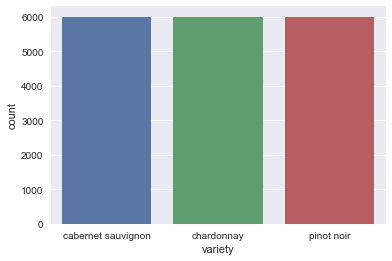

In [10]:
# Now let's take a another look at the data
sns.countplot(x='variety', data=test_df)
plt.show()

In order for the computer to understand what a "Pinot Noir" is, we need to translate it to numbers.

In [11]:
# Create a list of possible answers
varieties_list = list(test_df.variety.unique())
print(len(varieties_list))
# Create the key for the list
varieties_key = list(range(len(varieties_list)))

# Create the dictionary and insert the dictionary into our dataframe
variety_dict = dict(list(zip(varieties_list, varieties_key)))
inv_variety_dict = dict(list(zip(varieties_key, varieties_list)))
test_df['variety'] = test_df['variety'].replace(variety_dict)

# Print out the dictionary so we can understand what the computer is thinking
print(variety_dict)

3
{'cabernet sauvignon': 0, 'chardonnay': 1, 'pinot noir': 2}


## Prepare for Testing


Now, let's prep the descriptions for analysis first by cleaning out some of the punctuation.

In [12]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

test_df['description_text'] = test_df['description_text'].apply(text_cleaner)
test_df.head(10)

,country,description_text,variety
0,us,This is a sound Cabernet Sauvignon. It's very ...,0
1,chile,Rubber and earth aromas lead to a mix of berry...,0
2,us,The deep black color of this wine suggests tha...,0
3,us,This shows classic Cabernet Sauvignon characte...,0
4,chile,"Direct, woody aromas of cherry, raspberry and ...",0
5,us,Here's a rustic Cabernet. With the right foods...,0
6,italy,Here's an inky black and densely concentrated ...,0
7,us,A lovely Cabernet for drinking now. It's soft ...,0
8,us,"Rough, earthy and tannic, with simple, high-to...",0
9,us,"Made from 79% Cabernet Sauvignon, 13% Merlot a...",0


Let's create a function that will run all of the tests we need with the inputs of test, inputs (X,Y), and method.

In [13]:
#Create a testing function that will fit the test the data.
def testing_func(test, models, method):
    # This is a local list used to temporarily store scores
    scores=[]
    # This list serves the For loop below putting the variables in   
    for x in models:
        #Fitting to Training Data
        test.fit(x[0], x[1])
        #Training Data Score
        scores.append(test.score(x[0], x[1]))
        #Test Data Score
        scores.append(test.score(x[2], x[3]))
        #CV Score
        scores.append(np.mean(cross_val_score(test, x[0], x[1], cv=5)))
    
    # Create a local dataframe to display our results cleanly
    local_results_df=pd.DataFrame(scores, columns=['Accuracy'], index=[method])
    print(local_results_df)
 

## TF_IDF
First, let's use Term Frequency - Inverse Document Frequency (TF-IDF) to break the sentences down into vectors. What this will do is take the number of times a word appears in the description and penalize it if it appears in too many descriptions by multiplying it by the log (base 2) of the number of documents divided by the frequency of the word in all of the documents. This will result in words that appear in every description to be less important (through a lower weighting) when trying to decipher if the word is important for classification. Logically speaking, if a word appears in every sentence, it cannot be that helpful in distinguishing one sentence from another and this is what the machine will need to do to classify the descriptions to the varieties.

In [14]:
X = test_df['description_text']
y = test_df['variety']
#Applying the vectorizer
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
X = vect2.fit_transform(X)
#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train2, y_test2= train_test_split(X, y, test_size=0.4, random_state=0)

y_train2 = y_train2.astype(int)
y_test2 = y_test2.astype(int)


## LSA
Now let's use Latent Semantic Analysis (LSA) to improve the model through dimension reduction. This applies Principle Components Analysis (PCA) to the vector matrix.

In [15]:
# Apply Singular Value Decomposition to reduce dimensions without doing mean-center nromalizing. 
svd= TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

In [16]:
# Go ahead and create our X variable for unsupervised learning
tfidf_X = test_df['description_text']

#Applying the vectorizer
vect2 = TfidfVectorizer(min_df=20, analyzer = 'word', stop_words = 'english', ngram_range = (1,2))
tfidf_X = vect2.fit_transform(tfidf_X)
#Apply SVD for LSA which tends to work better for unsupervised learning techniques like clustering.
svd= TruncatedSVD(60)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lsa_X = lsa.fit_transform(tfidf_X)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

In [17]:
# Our X,Y for the models
models = [[X_train_tfidf, y_train2, X_test_tfidf, y_test2], [X_train_lsa, y_train2, X_test_lsa, y_test2]] 

# TF_IDF is the method
tf_idf_method = ['TF-IDF Training', 'TF-IDF Test', 'TF-IDF Cross Validation', 
                 'TF-IDF with LSA Training', 'TF-IDF with LSA Test', 'TF-IDF with LSA Cross Validation']



This is a multinomial classification, so not all statistical methods can handle classifications that are not binary. Of the ones that can, this project will use the following taking into consideration processing power: <br>
Logistic Regression <br>
SVC <br>
Random Forest

### Logistic Regression

Logistic Regression is an effective way to work with classification problems like this one by calculating the probabilities of each result and taking a log of the results creating a situation where linear regression can be used where it would otherwise not be possible.

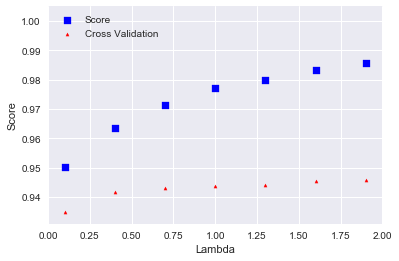


It took the following time to complete this task: 0:00:16.284419


In [18]:
start = datetime.now()
# Try to figure out the best Lambda for Logistic Regression by running the test with the PCA X variable and mapping them out.
# Temporary lists to store the results
yl = []
cl = []

# For loop to run the model with different Lambdas represented as L
numb = np.arange(0.1, 2.0, 0.3)
for l in numb:
    lr = LogisticRegression(C=l, multi_class='multinomial', solver='lbfgs')
    lr.fit(X_train_tfidf, y_train2)
    yl.append(lr.score(X_train_tfidf, y_train2))
    cl.append(np.mean(cross_val_score(lr, X_train_tfidf, y_train2, cv=5)))

# Plot the results of the accuracy and Cross Validation Score
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Lambda')
plt.ylabel('Score')
ax1.scatter(x=numb, y=yl, c='b', marker="s", label='Score')
ax1.scatter(x=numb, y=cl, s=10, c='r', marker="^", label='Cross Validation')
plt.legend(loc='upper left');
plt.show()
print('\nIt took the following time to complete this task:', datetime.now() - start)

In [19]:
start = datetime.now()
lr = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
testing_func(lr, models, tf_idf_method)
print('\nIt took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.977037
TF-IDF Test                       0.945972
TF-IDF Cross Validation           0.943612
TF-IDF with LSA Training          0.935463
TF-IDF with LSA Test              0.291111
TF-IDF with LSA Cross Validation  0.929076

It took the following time to complete this task: 0:00:04.419434


### Support Vector Machines

SVM uses a multi-dimensional hyperplane to classify based on the regularization parameter ("C") and Gamma. A lower C will look for a larger marigin hyperplane even if it misclassifies points leading to less overfitting, but potentially lower overall accuracy. Gamma looks at each individual training set point and which ones are considered. A higher gamma means that only close points will be considered while a low gamma means points far away will be considered when determining the hyperplane.

Luckily, Grid Search CV exists to assist in the optimization of "C" and gamma.

In [20]:
# SKlearn has a tool that will optimize SVC
start = datetime.now()
svc = LinearSVC(multi_class='ovr')
# Set the hyperparameters
svcparameters = {'C':[1,5,8]}
# Run it through the tool.
grid = GridSearchCV(svc, svcparameters).fit(X_train_tfidf, y_train2)
predicted = grid.predict(X_test_tfidf)
print("The best parameters are {} with a score of %{}".format(grid.best_params_, grid.best_score_))

#Put those parameters in a dictionary to call.
svcparameters = grid.best_params_

print('\nIt took the following time to complete this task:', datetime.now() - start)

The best parameters are {'C': 1} with a score of %0.9419444444444445

It took the following time to complete this task: 0:00:01.120353


In [21]:
start = datetime.now()
svc = LinearSVC(C=svcparameters['C'], multi_class='ovr')
testing_func(svc, models, tf_idf_method)
print('\nIt took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.993889
TF-IDF Test                       0.945972
TF-IDF Cross Validation           0.944722
TF-IDF with LSA Training          0.934444
TF-IDF with LSA Test              0.303333
TF-IDF with LSA Cross Validation  0.927872

It took the following time to complete this task: 0:00:01.660050


### Random Forest

Random Forest employs a bootstrapping method of taking random subsamples of data and creating a decision tree for the classifier. The number of estimators below is how many trees it is employing to make the decision. Max Depth is the layers of nodes in the trees. The deeper the tree, the more likely it is to overfit the classifier by going into variables that aren't important in making the ultimate decision. Due to the number of features and how they work in this model, it is working better with a deeper tree of 16 than models run with lower depths. <br>
<br>
n_jobs is set to 4 to account for parallel processing. With a quadcore CPU, each core is able to create decision trees cutting down the overall time it takes to create the forest of decision trees used to classify the wine variety.

In [22]:
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=1000, 
                                 max_depth=16, n_jobs=4)
testing_func(rfc, models, tf_idf_method)
print('\n It took the following time to complete this task:', datetime.now() - start)

                                  Accuracy
TF-IDF Training                   0.960370
TF-IDF Test                       0.933056
TF-IDF Cross Validation           0.927594
TF-IDF with LSA Training          0.999444
TF-IDF with LSA Test              0.276944
TF-IDF with LSA Cross Validation  0.929815

 It took the following time to complete this task: 0:03:35.589704


### Results

Both Logistic Regression and SVC are able to achieve accuracies around 94.3% with SVC taking half of the processing time as Logistic Regression. This is not bad. <br>
<br>
LSA on the other hand is creating overfitted models with poorer accuracy.

## Spacy
Now, let's prep the data for analysis using the natural language processor, Spacy. First, we need to create our functions for creating word counts and features based on those counts.

In [23]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

def bow_features(sentences, common_words):

    # Scaffold the data frame and initialize counts to zero.
    s_index = len(sentences)
    df = pd.DataFrame(columns=common_words, index=range(s_index))
    
    df['description_text'] = sentences['description_text']
    df['variety'] = sentences['variety']
    df = df.fillna(0)
    

    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['description_text']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
       
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1

        # This counter is just to make sure the kernel didn't hang.
        if i % 5000 == 0:
            print("Processing row {}".format(i))
            
    return df


In [24]:
start = datetime.now()
# Set up Spacy
nlp = spacy.load('en')
# Create a dataframe for our parsed descriptions and parse them.
parsed_wine = test_df
parsed_wine['description_text'] = parsed_wine['description_text'].apply(lambda x: nlp(x))

# Figure out the most common words
description_words = parsed_wine['description_text'].apply(bag_of_words)
flat_list = [item for sublist in description_words for item in sublist]
common_words = set(flat_list)

# Use the second function to count the appearance of the common words in each description
word_counts = bow_features(parsed_wine, common_words)
print(word_counts.head(10))
print('\nIt took the following time to complete this task:', datetime.now() - start)

Processing row 0
Processing row 5000
Processing row 10000
Processing row 15000
   bouquet  2021  2017–2022  brittan  strawberri  brew  unnecessarily  wink  \
0        0     0          0        0           0     0              0     0   
1        0     0          0        0           0     0              0     0   
2        0     0          0        0           0     0              0     0   
3        0     0          0        0           0     0              0     0   
4        0     0          0        0           0     0              0     0   
5        0     0          0        0           0     0              0     0   
6        0     0          0        0           0     0              0     0   
7        0     0          0        0           0     0              0     0   
8        0     0          0        0           0     0              0     0   
9        0     0          0        0           0     0              0     0   

   stint  rhythm                        ...        

Now that there are word counts for each description, let's use that to see if the computer can figure out what the  variety is by the descriptions. Since we are using word counts in a dataframe and not creating a vectorized dataset as above in TF_IDF, it is easy to add other features like country of origin for the wine, which may give an additional clue.

In [25]:
# Create the features of the countries in a binary format with 1 equalling where the country is from through dummies.
countries = pd.get_dummies(test_df, columns=['country'])
# Merge that into our word counts file.
word_counts = pd.merge(word_counts, countries)

# Set the X,Y and create a training/test set.
X = word_counts.drop(['variety', 'description_text'], 1)
y = word_counts['variety']

# Splitting into training and test sets
Spacy_X_train, Spacy_X_test, Spacy_y_train, Spacy_y_test= train_test_split(X, y, test_size=0.4, random_state=0)
print(set(Spacy_y_test), varieties_list)
# These will be the models for SpaCy
models = [[Spacy_X_train, Spacy_y_train, Spacy_X_test, Spacy_y_test]] 

# Let's tell it that it is SpaCy
Spacy_method = ['SpaCy Training', 'SpaCy Test', 'SpaCy CV']

{0, 1, 2} ['cabernet sauvignon', 'chardonnay', 'pinot noir']


Now, let's apply the same three models as above to get an apples to apples comparison.

### Logistic Regression

In [26]:
start = datetime.now()

# Putting it in multi-class and changing the solver allows it to handle multinomial classification
lr = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
testing_func(lr, models, Spacy_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  0.997841
SpaCy Test      0.952837
SpaCy CV        0.949879
It took the following time to complete this task: 0:02:11.782807


### SVC

In [27]:
start = datetime.now()
# The "ovr" method allows SVC to do multinomial classification
svc = LinearSVC(C=svcparameters['C'], multi_class='ovr')
testing_func(svc, models, Spacy_method)
print('It took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  1.000000
SpaCy Test      0.946361
SpaCy CV        0.938145
It took the following time to complete this task: 0:00:22.959259


### Random Forest

In [28]:
start = datetime.now()
rfc = RandomForestClassifier(n_estimators=1000, 
                                 max_depth=16, n_jobs=4)
testing_func(rfc, models, Spacy_method)
print('\nIt took the following time to complete this task:', datetime.now() - start)

                Accuracy
SpaCy Training  0.966585
SpaCy Test      0.940729
SpaCy CV        0.937489
It took the following time to complete this task: 0:02:44.324325


## Results

Spacy with Logistic Regression edged out the others performing the most accurately with over 94.6% accuracy. That's a pretty sharp model, but let's take a deeper dive into where it was making mistakes through a confusion matrix showing which ones it got wrong and which it got right (on the diagonal).

3 3


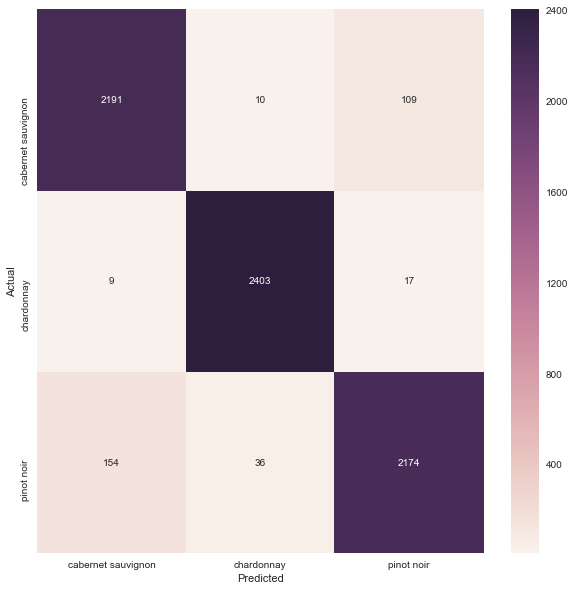

In [29]:
model = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
model.fit(Spacy_X_train, Spacy_y_train)
y_pred = model.predict(Spacy_X_test)
print(len(set(Spacy_y_test)), len(varieties_list))
conf_mat = confusion_matrix(Spacy_y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=varieties_list, yticklabels=varieties_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It looks like the mistakes were in the two red varieties. Part of the issue here is that some of the flavors of wines don't just come from the variety itself, but from how the wine is produced; such as the introduction of flavors of vanilla and cedar from oak ageing. While these notes can happen in any wine regardless of whether it is red or white, if the description is not too descriptive to begin with or focuses too much on the common flavors associated with oaking, it would be difficult for a human to distinguish what wine variety the author is speaking about, let alone a computer.

94% accuracy is a very sharp model.

## Unsupervised Learning

First, let's use the LSA generated X to see similarities in the wine descriptions to see the different aspects the machine sees in the data.

In [30]:
articles_by_component=pd.DataFrame(lsa_X,index=test_df['description_text']) 
articles_by_component.shape

print("Percent variance captured by all components:",total_variance*100)


for i in range(3): 
    print('Component {}:'.format(i)) 
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:5])



Percent variance captured by all components: 13.9527230338
Component 0:
description_text
(The, 2006, flagship, Cabernet, from, Quilceda, Creek, is, a, massive, wine, that, has, just, begun, to, emerge, from, its, slumber, ., When, first, released, the, wine, seemed, to, have, entered, a, dumb, phase, ,, but, six, months, later, it, responds, to, decanting, and, shows, its, muscle, ., Fruit, flavors, of, black, ,, brandied, cherries, ,, cassis, and, bourbon, -, soaked, plums, are, wrapped, in, generous, ,, layered, oak, ., The, wine, is, dusty, ,, smoky, ,, laced, with, streaks, of, licorice, and, brightened, with, sharp, acids, ., It, continues, to, expand, further, in, the, glass, ,, adding, flesh, and, spice, ...)    0.650468
(True, to, the, Clos, du, Val, paradigm, ,, this, wine, offers, ripe, California, fruit, rendered, traditionally, -, in, this, case, in, a, Burgundian, manner, ., The, fruit, rides, high, on, the, bright, acidity, ;, full, ,, meaty, black, cherry, and, earth, ar

LSA analysis pulls up similarities in the different components. Component 0 seems to really home in on red fruits such as cherries and raspberries in the descriptions. Component 1 has different wine descriptions that go into the wine's acidity, meaning it was of mention. Component 2 goes into the "rich" wines that are creamy, fruity, or complex in character.

Now, let's look at sentence similarity.

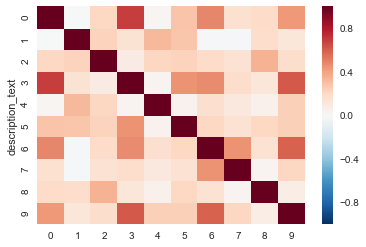

Key:
0 This is a sound Cabernet Sauvignon. It's very dry and quite tannic, with pure blackberry, black currant and blueberry flavors, and it finishes with a soft gentleness. At its best now, and the price is good for the quality.
1 Rubber and earth aromas lead to a mix of berry fruit scents and a pinch of vinegar. It's firm in the mouth, with cranberry and herbal raspberry flavors. Gives about as much as it can but at the same time it shows a tart, basic, mildly herbal DNA.
2 The deep black color of this wine suggests that it spent a lot of time on the skins, and 20 months in American oak added further grip and grit to the tannins. Cherry tobacco, espresso and plenty of oak flavors lead into a chewy finish with some residual bitterness.
3 This shows classic Cabernet Sauvignon character, and there's even a Bordeaux-like earthiness that grounds the cherry, currant and cedar flavors. Made from fruit grown in the winery's Alexander Valley vineyard, this is ideal for drinking now.
4 Direct,

In [31]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lsa_X) * np.asmatrix(lsa_X).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=test_df['description_text']).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


The strongest similarities are between the second and third sentences, which both discuss a wine with "plum" and "herbal" aromas. Sentences 1 and 5 also show similarities in their mentions of black fruits. Other sentences just show light to moderate similarity.

Now, let's try to use clusters to see if we can draw any other insights from the data. Using the PCA generated features (PCA with Spacy and LSA with the vectorized data) will help get better clusters.

In [32]:
Spacy_X = word_counts.drop(['description_text'], 1)
pca = PCA(n_components=20)
Spacy_X_pca = pca.fit_transform(Spacy_X)
Spacy_X_pca = pd.DataFrame(Spacy_X_pca)

In [33]:
start = datetime.now()
models = [Spacy_X_pca, lsa_X]
kclust = np.arange(2, 11, 2)
for k in kclust:
    # Calculate predicted values.
    kmeans = KMeans(n_clusters=k, random_state=0)
    for m in models:
        kmeans.fit(m)
        # Check the solution against the data.
        labelskm = kmeans.labels_
        print(k, metrics.silhouette_score(m, labelskm, metric='euclidean'))
print('\nIt took the following time to complete this task:', datetime.now() - start)

2 0.122801510417
2 0.0449405697063
4 0.105793284837
4 0.0479692776685
6 0.108251100015
6 0.0543264068389
8 0.0875289677606
8 0.0589799056353
10 0.0856320355925
10 0.0620427737275


In [34]:
start = datetime.now()
# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(lsa_X)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labelsaf = af.labels_
print(metrics.silhouette_score(lsa_X, labelsaf, metric='euclidean'))
print('\nIt took the following time to complete this task:', datetime.now() - start)

Done
0.0945563165842


Unfortunately, the algorithms were not able to produce good clusters from the data set with the highest rating coming from features generated by Principle Components Analysis with a silhouette score of 0.129. The closer the score is to zero, the more random the clusters are, so these are not very good clusters.

While the data is not binary per se, most wine descriptions do not have multiple occurrences of words other than colors making the data have binary qualities to it. PCA/LSA both help to solve that through creating features that are not binary in nature, but these new features still underperform. Increasing the rows of data used in the analysis might help, but the processing power of the MacBook Pro with an i5 processor cannot handle the calculations necessary and it crashes the kernel.

## Next Steps

This is a good start to using wine descriptions and natural language processing to discern grape varieties. There are a couple things to improve performance and increase the range of this analysis.

1) Better Data
While some of the wine descriptions are fine, some of the descriptions are one liners that say very little about the wine other than the author's impressions without precision (e.g. "Sharp Acidity"). A better dataset would have better quality descriptions. Students of WSET learn to "scientifically" assess wines using their Systematic Approach to Tasting (SAT) using descriptors that are common (and commonly understood). There are hundreds of students globally being taught the SAT at the highest levels and 9000 students who have passed the Diploma (highest) level. They taste hundreds of wines and write up their notes in preparation for the exam. If all passing students were to turn in their wine descriptions, it would be a pretty good dataset. 

2) Better Machine
Processing natural language takes a lot of processing power because the computer needs to break down thousands of words into their individual units and create features based on them. This MacBook Pro with an i5 processor cannot handle the amount of data desired.

While this project lays down the groundwork for applying supervised/unsupervised learning techniques on wine descriptions, making the above improvements could provide even better performance and insights across a wider spectrum of wine varieties that could improve our understanding of wine.